### 06 Colab 環境での Gradio UI の実装
#### 機能
- Google Colab 環境で Gradio を立ち上げする。
- Gradio UI に PDFファイルをドラッグアンドドロップで入力する。
- PDF ファイルが入力されたら、markdown に変換・前処理し、PDF の内容の先頭1000行を表示する。
- PDF の内容表示は、画面をスクロールして、表示内容の全文を確認できるようにする。
- Gradio UI にチャットインターフェース（ユーザ入力 / AI 回答）を設ける。
- AI チャットは、マルチターン対応、ストリーミング応答を行う。
- ユーザ入力 / AI 回答とも、画面をスクロールして、会話履歴含めた全文を確認できるようにする。
- **会話クリアボタン**: PDF を保持したまま会話履歴をリセットし、新しいスレッドで再質問できる。
- **システムプロンプト設定**: アコーディオン内で自由に編集可能。デフォルトは「日本語で回答してください。」
- **Temperature スライダー**: LLM の応答の正確さ/創造性を 0.0〜1.0 で調整できる。
- **生成停止ボタン**: ストリーミング中の応答を途中で中断できる。

#### 環境・要件
- Google Colab に Ollama をセットアップ
- ChatOllama で LLM に接続
- LangGraph によるLLMのメモリ管理
- LangGraph/LangChain によるチャット
- データの前処理
  - markdown に変換（MarkItDown を使用）
  - Unicode正規化 (NFKC), 1文字行ブロックの除去, 空行圧縮

**この notebook で使用しているテストデータ**
> [井澤克彦, 市川信一郎, 高速回転ホイール: 高速回転ホイール開発を通しての知見, 宇宙航空研究開発機構研究開発報告, 2008](https://jaxa.repo.nii.ac.jp/records/2149)

**必要なライブラリをインストール**
- 1行にまとめることで pip が全パッケージの依存関係を一括解決する。
- 分割すると後勝ちで依存関係が壊れるリスクがある。
- NOTE: Colab では uv ではなく pip を使う。
> uv は依存解決の過程で numpy 等をアップグレードし、プリインストール済みの scipy 等を壊すため。

In [1]:
# Google Colab に必要なライブラリをインストールする。
# 1行にまとめることで pip が全パッケージの依存関係を一括解決する。
# NOTE: Colab では uv ではなく pip を使う。uv は依存解決の過程で
#       numpy 等をアップグレードし、プリインストール済みの scipy 等を壊すため。
# NOTE: langchain 関連は 1.x 系に明示的に指定する。
#       Colab プリインストールの 0.3.x が残ると langchain-mcp-adapters が動作しない。
# Pythonのリストとして定義することで、Pylanceの警告を防ぎ、可読性を高める。

# fmt: off
pkgs = [
    "ollama", "langchain-ollama",
    "langchain>=1.2.8", "langchain-core>=1.2.8", "langgraph>=1.0.7",
    "markitdown[all]", "gradio>=6.0",
]
# fmt: on

# リストを結合して pip に渡す
# magic command内で {変数} を使うと展開される機能を利用
%pip install -U -q {" ".join(pkgs)}

**Google Colab に Ollama をセットアップ**
- Ollama のインストール, 起動, モデルのダウンロードを行う。
- 詳細は [01_connect_oss_llm.ipynb](01_connect_oss_llm.ipynb) を参照。

In [2]:
# Ollama のインストール・起動・モデルのダウンロード
# 詳細は 01_connect_oss_llm.ipynb を参照
import subprocess
import time
import ollama  # type: ignore

!apt-get install -y -qq zstd
!curl -fsSL https://ollama.com/install.sh | sh

process = subprocess.Popen(
    ["ollama", "serve"],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL,
)
time.sleep(5)


def ollama_pull(model: str) -> None:
    """Ollama モデルをダウンロードし、進捗をインライン表示する。

    NOTE: ollama pull のプログレスバーは Colab で文字化けするため、
          Python API 経由でステータスのみ表示する。
    """
    for progress in ollama.pull(model, stream=True):
        status = progress.get("status", "")
        total = progress.get("total") or 0
        completed = progress.get("completed") or 0
        if total:
            line = f"{status}: {completed / total:.0%}"
        else:
            line = status
        print(f"\r{line:<60}", end="", flush=True)
    print(f"\n{model}: Done!")


# AI エージェントにはツールコール対応モデルが必要。
model_name = "gpt-oss:20b"
ollama_pull(model_name)
!ollama show {model_name}

Selecting previously unselected package zstd.
(Reading database ... 121852 files and directories currently installed.)
Preparing to unpack .../zstd_1.4.8+dfsg-3build1_amd64.deb ...
Unpacking zstd (1.4.8+dfsg-3build1) ...
Setting up zstd (1.4.8+dfsg-3build1) ...
Processing triggers for man-db (2.10.2-1) ...
>>> Installing ollama to /usr/local
>>> Downloading ollama-linux-amd64.tar.zst
######################################################################## 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
success                                                     
gpt-oss:20b: Done!
  Model
    architecture        gptoss    
    parameters          20.9B     
    context length      131072    
    embedding length    2880      
    quantization        MXFP4     

  Ca

**ChatOllama で LLM に接続**
- 詳細は [01_connect_oss_llm.ipynb](01_connect_oss_llm.ipynb) を参照。

In [3]:
# ChatOllama で LLM に接続する。
from langchain_ollama import ChatOllama  # type: ignore

llm = ChatOllama(
    model="gpt-oss:20b",
    num_ctx=16384,
    num_predict=-1,
    temperature=0.8,
    top_k=40,
    top_p=0.9,
    repeat_penalty=1.1,
    reasoning=None,
)

### LangGraph によるメモリ付きチャットグラフの構築
**LangGraph によるLLMのメモリ管理**
- chat_node で、LLM を呼び出した際の処理を設定。
> 今回は人間のプロンプトを LLM に入力して、LLM から応答を取得する処理。
- LangGraph のグラフを構築し、ノードとエッジを設定し、グラフを compile する。
> 今回は単純だが、各処理をつなげて自動化させる場合に効果を発揮する。
- InMemorySaver を使用して、LLM との会話をメモリに保存させる。
> LLM とのチャット履歴が保持されるようになる。
- 作成したグラフを図示する。

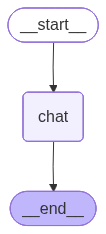

In [4]:
# LangGraph によるメモリ付きチャットグラフの構築
# InMemorySaver を使って、スレッド（thread_id）ごとに会話履歴を保持する
from langgraph.graph import StateGraph, MessagesState, START, END  # type: ignore
from langgraph.checkpoint.memory import InMemorySaver  # type: ignore
from langchain_core.runnables import RunnableConfig  # type: ignore
from IPython.display import Image, display


def _make_llm(temperature: float) -> ChatOllama:
    """指定した temperature で ChatOllama インスタンスを生成する。
    temperature 以外のパラメータはベースの llm から引き継ぐ。

    Args:
        temperature: LLM の応答のランダム性（0.0=正確、1.0=創造的）。

    Returns:
        ChatOllama: 指定 temperature で構成された LLM インスタンス。
    """
    return ChatOllama(
        model=llm.model,
        num_ctx=llm.num_ctx,
        num_predict=llm.num_predict,
        temperature=temperature,
        top_k=llm.top_k,
        top_p=llm.top_p,
        repeat_penalty=llm.repeat_penalty,
        reasoning=llm.reasoning,
    )


def chat_node(state: MessagesState, config: RunnableConfig) -> dict:
    """LangGraph チャットノード。会話履歴を LLM に送信し、応答を返す。

    config 経由で temperature を受け取り、動的に LLM インスタンスを生成する。
    これによりグラフを毎回再構築せずに temperature を切り替えられる。

    Args:
        state: LangGraph の MessagesState。"messages" キーに会話履歴を持つ。
        config: LangGraph の RunnableConfig。config["configurable"]["temperature"]
                で LLM の temperature を指定する（デフォルト: llm.temperature）。

    Returns:
        dict: {"messages": [response]} 形式。LLM の応答メッセージを含む。
    """
    temp = config["configurable"].get("temperature", llm.temperature)
    response = _make_llm(temp).invoke(state["messages"])
    return {"messages": [response]}


# グラフの構築
graph = StateGraph(MessagesState)
graph.add_node("chat", chat_node)
graph.add_edge(START, "chat")
graph.add_edge("chat", END)

# InMemorySaver：スレッドごとに会話履歴をインメモリで保持
memory = InMemorySaver()
app = graph.compile(checkpointer=memory)

# 構築したグラフを図示
display(Image(app.get_graph().draw_mermaid_png()))

**データの前処理関数の定義**
- MarkItDown で PDF → markdown に変換する。
- 前処理: Unicode正規化 (NFKC), 1文字行ブロックの除去, 空行圧縮を行う。
- 詳細は [04_AI_Embedding_RAG.ipynb](04_AI_Embedding_RAG.ipynb) を参照。

In [5]:
# PDF → markdown 変換 + 前処理（Unicode正規化, ゴミ除去, 空行圧縮）
# 詳細は 04_AI_Embedding_RAG.ipynb を参照
import re
import unicodedata
from markitdown import MarkItDown  # type: ignore


def clean_pdf_text(text: str) -> str:
    """PDF 抽出テキストの汎用クリーニングを行う。

    1. 1文字行が 3 行以上連続するブロックを除去（図表・縦書き由来のゴミ）
    2. 連続する空行を 2 つまでに圧縮
    """
    text = re.sub(
        r"(^[^\S\n]*\S[^\S\n]*$\n?){3,}",
        "\n",
        text,
        flags=re.MULTILINE,
    )
    text = re.sub(r"\n{3,}", "\n\n", text)
    return text.strip()


def process_pdf(filepath: str) -> str:
    """PDF ファイルを markdown に変換し、前処理を行う。"""
    md = MarkItDown()
    result = md.convert(filepath)
    text = result.text_content

    # Unicode 正規化 (NFKC)
    text = unicodedata.normalize("NFKC", text)

    # クリーニング
    text = clean_pdf_text(text)
    return text


print("process_pdf 関数を定義しました。")

process_pdf 関数を定義しました。


**Gradio UI の実装**
- 左カラム: PDF ファイルのドラッグ＆ドロップ入力と、変換後テキストの表示（先頭1000行、スクロール可能）
- 右カラム: マルチターン対応のチャットインターフェース（会話履歴スクロール可能）
  - システムプロンプト設定（アコーディオン内、デフォルト非表示）
  - Temperature スライダー（0.0〜1.0）で応答の正確さ/創造性を調整
  - 送信 / 生成停止 / 会話クリア ボタンを配置
- PDF をアップロードすると、新しい会話スレッドが開始される。
- 「会話をクリア」で PDF を保持したまま新スレッドで再質問可能。
- 「生成を停止」でストリーミング中の応答を中断可能。
- `gr.State()` でユーザー（ブラウザタブ）ごとにセッション状態を管理する。
- `share=True` で Colab 環境からでもパブリック URL でアクセス可能。

**Gradio の概要**

Blocks（UI（テキストボックスなど））, State（Gradio アプリのメモリ）, イベント（トリガー）, ユーザー定義関数（ロジック）から構成される。
1. **Blocks** ：アプリ全体の「レイアウト」を定義する。
> Row（横並び）や Column（縦並び）を使って、ボタン、テキストボックス、チャット窓などのコンポーネントを配置します。
2. **State** ：Gradio を起動すると立ち上がるブラウザのタブごとに、独立した「メモリ」を保持する。State は、画面には表示されない「ユーザーごとの変数」（ユーザが定義する必要あり）
> 今回のコードでは、PDFの全文データや、会話を識別するための thread_id を保存するために使用し、複数ユーザーが同時にアクセスしても会話が混ざらないようになっている。
3. **イベント** ：「何をした時に、何が起きるか」という動作のトリガーを定義します。
> 「ファイルが変更された（.change）」「ボタンが押された（.click）」「Enterキーが押された（.submit）」といった操作を検知する。
4. **ユーザー定義関数** ：イベントによって呼び出される、**実際の処理（Pythonコード）**。
> Gradioのイベント設定によって、「画面の入力値（inputs）」と「現在のセッション状態（state）」を受け取り、処理結果を return または yield することで、「画面の表示（outputs）」と「セッション状態（state）」を最新の状態に更新する。

**各実装の解説**

<u>`on_pdf_upload`, `on_clear_chat`</u>
- `filepath` ：Gradio のイベントボックス（`.File`）にファイルを入力すると、自動で作成される。今回は Colab 上で動作させており、Colab の一時フォルダとなる。
- Gradio 内での新しいセッションの作成。`.copy()` で作成し、次の 2行で初期化している。セッションの id は、番号が一意になるように、`uuid4()` で乱数によって生成している。
  - `new_state = state.copy()`
  - `new_state["pdf_text"] = text`
  - `new_state["thread_id"] = str(uuid.uuid4())` # uuid4()：乱数で一意になる id を生成
- `return display_text, [], new_state` ：`[]` はチャット履歴を空で返している。

<u>`_make_llm` / `chat_node`</u>
> コードは、**LangGraph によるメモリ付きチャットグラフの構築** を参照。

> UI に、LLM の `temperature` パラメータを調整できるスライダーを設けている。`chat_node` は `config["configurable"]["temperature"]` から値を取得し、`chat_node` 内の動作として、`_make_llm` で LLM インスタンスを生成する。グラフは一度だけ構築し、`temperature` は `config` 経由で、AI とチャットを行うたびに、毎回渡す。（AI の記憶などは、別変数で管理しているので、チャットの会話履歴などには影響しない。）

<u>`respond`</u>
- `config = {"configurable": {"thread_id": ..., "temperature": ...}}` ：
> `thread_id` で LLM の記憶を管理し、`temperature` でノード内の LLM 生成パラメータを制御する。グラフ自体は **LangGraph によるメモリ付きチャットグラフの構築** で構築済みの `app` をそのまま使う。
- `chat_history` ：Gradio の Chatbot 形式のデータで、ユーザ側 / AI の会話の履歴情報。システムプロンプトは含まれない。（要は、 Gradio UI の画面で見られる情報。）

In [13]:
# Gradio UI: PDF アップロード + AI チャット（ストリーミング応答）
import uuid
import gradio as gr  # type: ignore
from langchain_core.messages import HumanMessage, SystemMessage  # type: ignore


def on_pdf_upload(filepath: str, state: dict) -> tuple[str, list, dict]:
    """PDF アップロード時: markdown 変換・前処理し、先頭1000行を返す。
    同時にチャット履歴をリセットし、新しい会話スレッドを開始する。

    Args:
        filepath: Gradio の File コンポーネントが生成した一時ファイルパス。
        state: セッション状態。"pdf_text" と "thread_id" を含む辞書。

    Returns:
        tuple[str, list, dict]:
            - display_text: PDF テキストの先頭1000行（表示用）。
            - chat_history: 空リスト（チャット履歴のリセット）。
            - new_state: 更新されたセッション状態。
    """
    if filepath is None:
        return "PDF ファイルをドラッグ＆ドロップしてください。", [], state

    text = process_pdf(filepath)

    # State の更新（新しいスレッド ID を発行）
    new_state = state.copy()
    new_state["pdf_text"] = text
    new_state["thread_id"] = str(uuid.uuid4())

    # 先頭1000行を表示用に切り出す
    lines = text.split("\n")[:1000]
    display_text = "\n".join(lines)
    if len(text.split("\n")) > 1000:
        display_text += "\n\n... (1000行以降は省略)"

    return display_text, [], new_state  # チャット履歴もリセット


def on_clear_chat(state: dict) -> tuple[list, dict]:
    """会話履歴をクリアし、新しいスレッド ID を発行する。
    PDF テキストはそのまま保持するため、同じ文書で話題を変えられる。

    Args:
        state: セッション状態。"pdf_text" と "thread_id" を含む辞書。

    Returns:
        tuple[list, dict]:
            - chat_history: 空リスト（チャット履歴のリセット）。
            - new_state: 新しい thread_id を持つ更新済みセッション状態。
    """
    new_state = state.copy()
    new_state["thread_id"] = str(uuid.uuid4())
    return [], new_state


def respond(
    message: str,
    chat_history: list,
    state: dict,
    system_prompt: str,
    temperature: float,
):
    """ユーザのメッセージを LLM に送信し、ストリーミングで応答を返す。

    Args:
        message: ユーザが入力したメッセージ文字列。
        chat_history: Gradio Chatbot 形式の会話履歴リスト。
        state: セッション状態。"pdf_text" と "thread_id" を含む辞書。
        system_prompt: LLM に与えるシステムプロンプト。
        temperature: LLM の応答のランダム性（0.0〜1.0）。

    Yields:
        tuple[str, list, dict]:
            - msg_input: 空文字列（入力欄のクリア）。
            - chat_history: 応答トークンが追記された会話履歴。
            - state: セッション状態（変更なし）。
    """

    # 空入力の防止
    if not message.strip():
        yield "", chat_history, state
        return

    # LLM の temperature パラメータとメモリ管理の設定
    config = {
        "configurable": {
            "thread_id": state["thread_id"],
            "temperature": temperature,
        }
    }
    messages = []

    # 会話の最初（履歴が空）ならシステムプロンプトを設定する
    if not chat_history:
        system_content = system_prompt
        if state["pdf_text"]:
            # num_ctx=16384 に収まるよう、PDF テキストを制限する
            pdf_excerpt = state["pdf_text"][:10000]
            system_content += (
                "\n\n以下はアップロードされた PDF の内容です。"
                "この内容に基づいて回答してください:\n\n"
                f"{pdf_excerpt}"
            )
        messages.append(SystemMessage(content=system_content))

    messages.append(HumanMessage(content=message))

    # ユーザーメッセージと空のアシスタントメッセージを追加
    chat_history = chat_history + [
        {"role": "user", "content": message},
        {"role": "assistant", "content": ""},
    ]

    # stream_mode="messages" でトークン単位のストリーミング
    bot_reply = ""
    for chunk, metadata in app.stream(
        {"messages": messages}, config=config, stream_mode="messages"
    ):
        if chunk.content:
            bot_reply += chunk.content
            chat_history[-1] = {"role": "assistant", "content": bot_reply}
            yield "", chat_history, state


# --- Gradio UI の構築 ---
with gr.Blocks(title="PDF チャットアシスタント") as demo:
    gr.Markdown("### PDF チャットアシスタント")

    # ユーザー（ブラウザタブ）ごとのセッション状態を保持する
    session_state = gr.State(
        {
            "pdf_text": "",
            "thread_id": str(uuid.uuid4()),
        }
    )

    with gr.Row():
        # 左カラム: PDF アップロード + 内容表示
        with gr.Column(scale=1):
            pdf_input = gr.File(
                label="PDF ファイルをドラッグ＆ドロップ",
                file_types=[".pdf"],
                type="filepath",
            )
            pdf_display = gr.Textbox(
                label="PDF 内容（先頭1000行）",
                lines=25,
                max_lines=25,
                interactive=False,
            )

        # 右カラム: チャットインターフェース
        with gr.Column(scale=1):
            chatbot = gr.Chatbot(
                label="AI チャット",
                height=400,
            )

            # システムプロンプト設定（アコーディオン）
            with gr.Accordion("システムプロンプト設定 (任意)", open=False):
                system_prompt_input = gr.Textbox(
                    label="システムプロンプト",
                    value="日本語で回答してください。",
                    lines=2,
                )

            # Temperature スライダー（初期値はベース LLM の設定に合わせる）
            temp_slider = gr.Slider(
                minimum=0.0,
                maximum=1.0,
                value=llm.temperature,
                step=0.1,
                label="Temperature (低いほど正確、高いほど創造的)",
            )

            msg_input = gr.Textbox(
                label="メッセージを入力",
                placeholder="質問を入力してください...",
                lines=2,
            )
            with gr.Row():
                send_btn = gr.Button("送信", variant="primary")
                stop_btn = gr.Button("生成を停止", variant="stop")
                clear_btn = gr.Button("会話をクリア", variant="secondary")

    # --- イベントハンドラの設定 ---

    # PDF アップロード
    pdf_input.change(
        on_pdf_upload,
        inputs=[pdf_input, session_state],
        outputs=[pdf_display, chatbot, session_state],
    )

    # 送信（ストリーミング応答）— イベントを変数に保持して停止ボタンに渡す
    submit_args = dict(
        fn=respond,
        inputs=[msg_input, chatbot, session_state, system_prompt_input, temp_slider],
        outputs=[msg_input, chatbot, session_state],
    )
    submit_event_click = send_btn.click(**submit_args)
    submit_event_enter = msg_input.submit(**submit_args)

    # 生成停止ボタン
    stop_btn.click(
        fn=None,
        inputs=None,
        outputs=None,
        cancels=[submit_event_click, submit_event_enter],
    )

    # 会話クリアボタン
    clear_btn.click(
        on_clear_chat,
        inputs=[session_state],
        outputs=[chatbot, session_state],
    )

# Colab 環境では share=True でパブリック URL を生成する
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://805b4a20e3ac21f118.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [14]:
demo.close()

Closing server running on port: 7860


![Gradio UI の画面](https://github.com/IS-reaction-wheel/GEN_AI_RAG/raw/main/images/notebook_06.png)